In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir('../../')

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Transfer success and Zest correlation

Here we will take a look at transfer rate of adversarial examples computed on different models,
and we will examine if there is a correlation with the Zest distance between the
respective models.

In [4]:
res_32 = 'results/distances_32_all_densenet121_densenet161_densenet169_googlenet_inception_v3_mobilenet_v2_resnet18_resnet34_resnet50_vgg11_bn_vgg13_bn_vgg16_bn_vgg19_bn.npy'
res_64 = 'results/distances_64_all_densenet121_densenet161_densenet169_googlenet_inception_v3_mobilenet_v2_resnet18_resnet34_resnet50_vgg11_bn_vgg13_bn_vgg16_bn_vgg19_bn.npy'
res_128 = 'results/distances_128_all_densenet121_densenet161_densenet169_googlenet_inception_v3_mobilenet_v2_resnet18_resnet34_resnet50_vgg11_bn_vgg13_bn_vgg16_bn_vgg19_bn.npy'

all_res = [res_32, res_64, res_128]
res_N = [32, 64, 128]
N = 32

transfer_res_file = 'results/transfer_densenet121_densenet161_densenet169_googlenet_inception_v3_mobilenet_v2_resnet18_resnet34_resnet50_vgg11_bn_vgg13_bn_vgg16_bn_vgg19_bn.npy'
dataset = 'CIFAR10'
all_proxies = [
    'vgg11_bn',
    'vgg13_bn',
    'vgg16_bn',
    'vgg19_bn',
    'resnet18',
    'resnet34',
    'resnet50',
    'densenet121',
    'densenet161',
    'densenet169',
    'mobilenet_v2',
    'googlenet',
    'inception_v3'
]
all_proxies = sorted(all_proxies)

# metric = 'Cosine'
metric = 'L-inf'
metrics = ['Cosine', 'L-inf']

## Zest distances

In [5]:
def inn_inf(v):
    return {i: j[2] for i,j in v.items()}
def inn_cos(v):
    return {i: j[3] for i,j in v.items()}

In [6]:
distance_dfs = {}
for cur_res in all_res:
    all_dist = np.load(cur_res, allow_pickle=True).item()

    all_dist_inf = {k: inn_inf(v) for k, v in all_dist.items()}
    all_dist_cos = {k: inn_cos(v) for k, v in all_dist.items()}
    
    all_inf_df = pd.DataFrame.from_dict(all_dist_inf)
    all_cos_df = pd.DataFrame.from_dict(all_dist_cos)
    all_inf_df = all_inf_df.sort_index()
    all_cos_df = all_cos_df.sort_index()

    both_df = pd.concat([all_inf_df, all_cos_df], keys=["L-inf", "Cosine"])
    
    distance_dfs[int(cur_res.split('_')[1])] = both_df

## Transfer rates

In [7]:
transfer_res = np.load(transfer_res_file, allow_pickle=True).item()


Victim model: densenet121



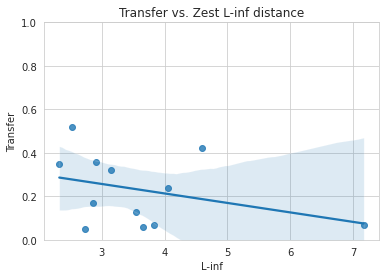

          Transfer     L-inf
Transfer  1.000000 -0.353255
L-inf    -0.353255  1.000000
--------------------------------------------------------------------------------

Victim model: densenet161



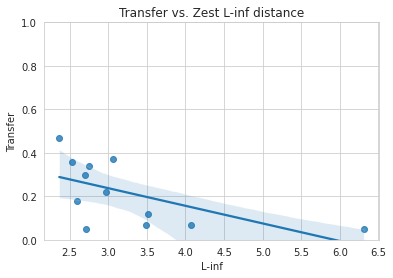

          Transfer    L-inf
Transfer   1.00000 -0.59342
L-inf     -0.59342  1.00000
--------------------------------------------------------------------------------

Victim model: densenet169



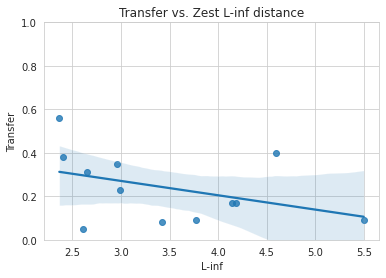

          Transfer     L-inf
Transfer  1.000000 -0.406913
L-inf    -0.406913  1.000000
--------------------------------------------------------------------------------

Victim model: googlenet



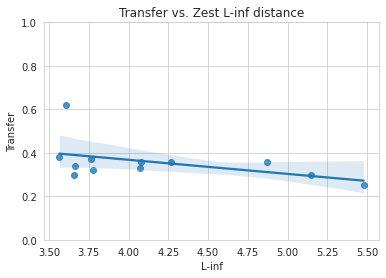

          Transfer     L-inf
Transfer  1.000000 -0.469059
L-inf    -0.469059  1.000000
--------------------------------------------------------------------------------

Victim model: inception_v3



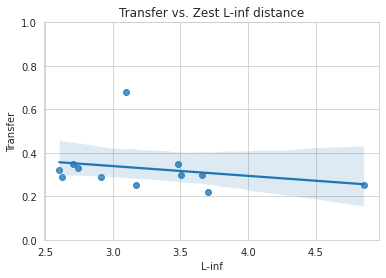

          Transfer     L-inf
Transfer  1.000000 -0.245496
L-inf    -0.245496  1.000000
--------------------------------------------------------------------------------

Victim model: mobilenet_v2



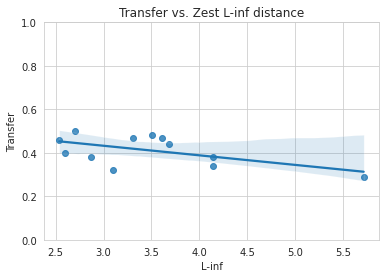

          Transfer     L-inf
Transfer  1.000000 -0.566349
L-inf    -0.566349  1.000000
--------------------------------------------------------------------------------

Victim model: resnet18



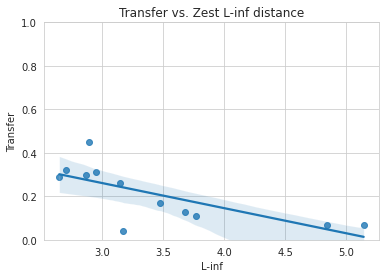

          Transfer     L-inf
Transfer  1.000000 -0.725594
L-inf    -0.725594  1.000000
--------------------------------------------------------------------------------

Victim model: resnet34



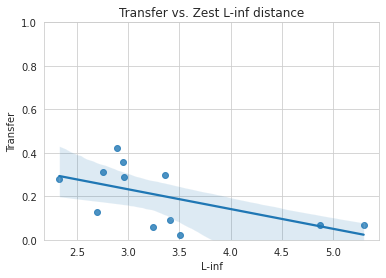

          Transfer     L-inf
Transfer  1.000000 -0.572997
L-inf    -0.572997  1.000000
--------------------------------------------------------------------------------

Victim model: resnet50



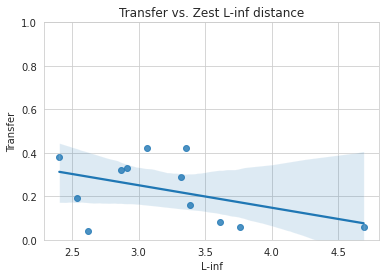

          Transfer     L-inf
Transfer  1.000000 -0.443463
L-inf    -0.443463  1.000000
--------------------------------------------------------------------------------

Victim model: vgg11_bn



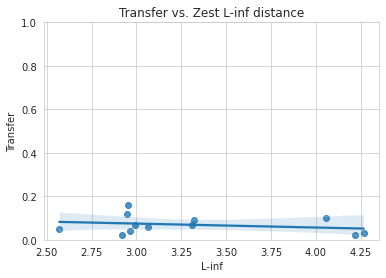

          Transfer    L-inf
Transfer   1.00000 -0.24184
L-inf     -0.24184  1.00000
--------------------------------------------------------------------------------

Victim model: vgg13_bn



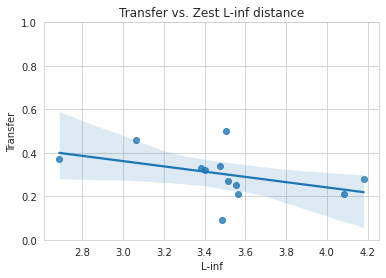

          Transfer     L-inf
Transfer  1.000000 -0.423698
L-inf    -0.423698  1.000000
--------------------------------------------------------------------------------

Victim model: vgg16_bn



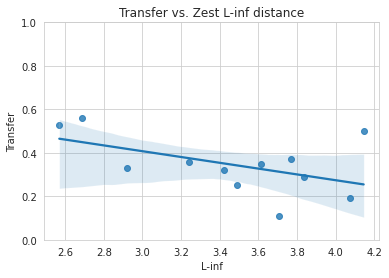

          Transfer     L-inf
Transfer  1.000000 -0.510832
L-inf    -0.510832  1.000000
--------------------------------------------------------------------------------

Victim model: vgg19_bn



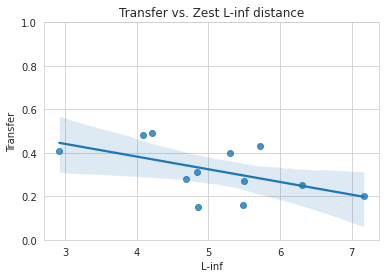

          Transfer     L-inf
Transfer  1.000000 -0.534266
L-inf    -0.534266  1.000000
--------------------------------------------------------------------------------


In [8]:
corrs = {}
for victim_model, cur_res in transfer_res.items():
    print('\nVictim model: {}\n'.format(victim_model))
    res_df = pd.DataFrame.from_dict(cur_res).drop(columns=['preds']).rename(columns={'successes': 'Transfer'})
    dist = distance_dfs[N].filter(like=metric, axis=0).reset_index(level=0, drop=True).loc[victim_model].drop(labels=[victim_model])
    res = res_df.drop(labels=[victim_model])
    res[metric] = dist

    # Show regression plot
    sns.set_style('whitegrid')
    plt.ylim(0, 1)
    s = sns.regplot(data=res, y='Transfer', x=metric, truncate=True)
    s.set(title='Transfer vs. Zest {} distance'.format(metric))
    plt.show()

    # Show correlation
    print(res.corr())
    corrs[victim_model] = res.corr().to_numpy()[0][1]
    print('-'*80)

In [9]:
corrs = {}
for victim_model, cur_res in transfer_res.items():
    corrs[victim_model] = {}
    for metric in metrics:
        res_df = pd.DataFrame.from_dict(cur_res).drop(columns=['preds']).rename(columns={'successes': 'Transfer'})
        dist = distance_dfs[N].filter(like=metric, axis=0).reset_index(level=0, drop=True).loc[victim_model].drop(labels=[victim_model])
        res = res_df.drop(labels=[victim_model])
        res[metric] = dist

        # Show correlation
        corrs[victim_model][metric] = res.corr().to_numpy()[0][1]

In [10]:
corrs_df = pd.DataFrame.from_dict(corrs, orient='index')
corrs_df.index.name = 'Model'
print(corrs_df.to_latex(
    float_format="%.3f",
    caption='Pearson correlation between transfer rate and Zest distance.',
    escape=False,
))

\begin{table}
\centering
\caption{Pearson correlation between transfer rate and Zest distance.}
\begin{tabular}{lrr}
\toprule
{} &  Cosine &  L-inf \\
Model        &         &        \\
\midrule
densenet121  &  -0.808 & -0.353 \\
densenet161  &  -0.850 & -0.593 \\
densenet169  &  -0.795 & -0.407 \\
googlenet    &  -0.437 & -0.469 \\
inception_v3 &  -0.590 & -0.245 \\
mobilenet_v2 &  -0.148 & -0.566 \\
resnet18     &  -0.732 & -0.726 \\
resnet34     &  -0.722 & -0.573 \\
resnet50     &  -0.698 & -0.443 \\
vgg11_bn     &   0.008 & -0.242 \\
vgg13_bn     &  -0.371 & -0.424 \\
vgg16_bn     &  -0.718 & -0.511 \\
vgg19_bn     &  -0.700 & -0.534 \\
\bottomrule
\end{tabular}
\end{table}

